In [1]:
import keras
import numpy as np
from keras import activations

Using TensorFlow backend.


In [2]:
from keras import layers
from keras.layers import BatchNormalization, Convolution2D, Input, merge, Cropping2D
from keras.layers.core import Activation, Layer

def conv_block(feat_maps_out, prev):
    prev = Conv2D(feat_maps_out, 3, padding='valid')(prev)
    prev = BatchNormalization()(prev)
    prev = Activation('relu')(prev)
    prev = Conv2D(feat_maps_out, 3, padding='valid')(prev) 
    prev = BatchNormalization()(prev)
    return prev

def Residual(feat_maps_in, feat_maps_out, prev_layer):
    '''
    A customizable residual unit with convolutional and shortcut blocks
    Args:
      feat_maps_in: number of channels/filters coming in, from input or previous layer
      feat_maps_out: how many output channels/filters this block will produce
      prev_layer: the previous layer
    '''

    skip = Cropping2D(cropping=((2,2),(2,2)))(prev_layer)
    
    conv = conv_block(feat_maps_out, prev_layer)

    print('Residual block mapping '+str(feat_maps_in)+' channels to '+str(feat_maps_out)+' channels built')

    return layers.add([skip, conv]) # the residual connection


In [3]:
from keras.models import Input, Model
from keras.layers import Conv2D
from keras.layers import Deconv2D

In [4]:
import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec
from keras.layers import ZeroPadding2D, Layer, InputSpec
import keras.backend as K 
# Extending the ZeroPadding2D layer to do reflection padding instead.
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), dim_ordering='default', **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)

        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()

        self.padding = padding
        if isinstance(padding, dict):
            if set(padding.keys()) <= {'top_pad', 'bottom_pad', 'left_pad', 'right_pad'}:
                self.top_pad = padding.get('top_pad', 0)
                self.bottom_pad = padding.get('bottom_pad', 0)
                self.left_pad = padding.get('left_pad', 0)
                self.right_pad = padding.get('right_pad', 0)
            else:
                raise ValueError('Unexpected key found in `padding` dictionary. '
                                 'Keys have to be in {"top_pad", "bottom_pad", '
                                 '"left_pad", "right_pad"}.'
                                 'Found: ' + str(padding.keys()))
        else:
            padding = tuple(padding)
            if len(padding) == 2:
                self.top_pad = padding[0]
                self.bottom_pad = padding[0]
                self.left_pad = padding[1]
                self.right_pad = padding[1]
            elif len(padding) == 4:
                self.top_pad = padding[0]
                self.bottom_pad = padding[1]
                self.left_pad = padding[2]
                self.right_pad = padding[3]
            else:
                raise TypeError('`padding` should be tuple of int '
                                'of length 2 or 4, or dict. '
                                'Found: ' + str(padding))

        if dim_ordering not in {'tf'}:
            raise ValueError('dim_ordering must be in {tf}.')
        self.dim_ordering = dim_ordering
        self.input_spec = [InputSpec(ndim=4)] 


    def call(self, x, mask=None):
        top_pad=self.top_pad
        bottom_pad=self.bottom_pad
        left_pad=self.left_pad
        right_pad=self.right_pad        
        
        paddings = [[0,0],[left_pad,right_pad],[top_pad,bottom_pad],[0,0]]

        
        return tf.pad(x,paddings, mode='REFLECT', name=None)

    def compute_output_shape(self,input_shape):
        if self.dim_ordering == 'tf':
            rows = input_shape[1] + self.top_pad + self.bottom_pad if input_shape[1] is not None else None
            cols = input_shape[2] + self.left_pad + self.right_pad if input_shape[2] is not None else None

            return (input_shape[0],
                    rows,
                    cols,
                    input_shape[3])
        else:
            raise ValueError('Invalid dim_ordering:', self.dim_ordering)
            
    def get_config(self):
        config = {'padding': self.padding}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))     
    

class Denormalize(Layer):
    '''
    Custom layer to denormalize the final Convolution layer activations (tanh)
    Since tanh scales the output to the range (-1, 1), we add 1 to bring it to the
    range (0, 2). We then multiply it by 127.5 to scale the values to the range (0, 255)
    '''

    def __init__(self, **kwargs):
        super(Denormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        '''
        Scales the tanh output activations from previous layer (-1, 1) to the
        range (0, 255)
        '''

        return (x + 1) * 127.5

    def compute_output_shape(self,input_shape):
        return input_shape

    
    


In [5]:
"""
In this cell I define, functionally, the "image transformation" network from jc johnson's and li fei fei paper.
"""

inputs = Input(shape=[256, 256, 3])
o = ReflectionPadding2D(padding=(40,40))(inputs) #TODO: Check if the reflection padding is done as the paper
o = Conv2D(32, (9, 9), strides=(1,1), padding='same', activation='relu')(o)
o = BatchNormalization()(o)
o = Conv2D(64, (3, 3), strides=(2,2), padding='same', activation='relu')(o)
o = BatchNormalization()(o)
o = Conv2D(128, (3, 3), strides=(2,2), padding='same', activation='relu')(o)
o = Residual(128, 128, o)
o = Residual(128, 128, o)
o = Residual(128, 128, o)
o = Residual(128, 128, o)
o = Residual(128, 128, o)
o = Deconv2D(64, (3, 3), strides=2, padding='same', activation='relu')(o)
o = BatchNormalization()(o)
o = Deconv2D(32, (3, 3), strides=2, padding='same', activation='relu')(o) #TODO: check if the output of this layer is the same as the fractional stride conv
o = BatchNormalization()(o)
o = Conv2D(3, (9, 9), strides=1, activation='tanh', padding='same')(o)
o = Denormalize()(o)

model_style_transfer = Model(inputs=inputs, outputs=o)


Residual block mapping 128 channels to 128 channels built
Residual block mapping 128 channels to 128 channels built
Residual block mapping 128 channels to 128 channels built
Residual block mapping 128 channels to 128 channels built
Residual block mapping 128 channels to 128 channels built


In [6]:
from keras.applications import VGG16

In [7]:
model_style_transfer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 336, 336, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 336, 336, 32) 7808        reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 336, 336, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
vgg = VGG16(include_top=False)

In [9]:
vgg.summary() # let's see where to get our outputs for style

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
relu1_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=2).output])
relu2_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=5).output])
relu3_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=9).output])
relu4_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=13).output])

In [11]:
import cv2

In [12]:
im = cv2.imread("fortnite/34.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

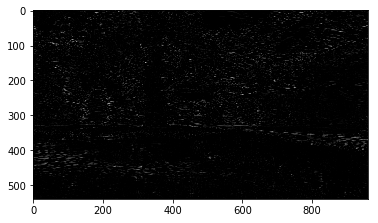

In [13]:
provaoutput = relu2_2.predict(np.array([im]))[0,:,:,80]

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(provaoutput, cmap='gray')
plt.show()

In [14]:
import tensorflow as tf
import keras.backend as K

def gram_matrix_pre(x):
    features = np.transpose(x, (2, 0, 1)).flatten()

    shape = np.shape(x)
    
    C, W, H = (shape[2],shape[0], shape[1])
    print('pre')
    print(shape)
    cf = np.reshape(features ,(C,-1))
    gram = np.dot(cf, np.transpose(cf)) /  np.float32(C*W*H)

    return gram

def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    shape = K.shape(x)
    print('post')
    print (shape)
    C, W, H = (shape[2],shape[0], shape[1])
    
    cf = K.reshape(features ,(C,-1))
    gram = K.dot(cf, K.transpose(cf)) /  K.cast(C*W*H,dtype='float32')

    return gram




In [15]:
im = cv2.resize(im, (256, 256))
style_gram_1 = gram_matrix_pre(relu1_2.predict(np.array([im]))[0])
style_gram_2 = gram_matrix_pre(relu2_2.predict(np.array([im]))[0])
style_gram_3 = gram_matrix_pre(relu3_3.predict(np.array([im]))[0])
style_gram_4 = gram_matrix_pre(relu4_3.predict(np.array([im]))[0])

pre
(256, 256, 64)
pre
(128, 128, 128)
pre
(64, 64, 256)
pre
(32, 32, 512)


In [16]:
style_gram_4.shape

(512, 512)

In [17]:
import os
path = '/datasets/'#/coco-2014-train/'
path_actual = '/datasets/coco-2014-train/'
X = [cv2.imread(path_actual+name) for name in os.listdir(path_actual)[:50]]
X = [cv2.resize(item, (256, 256)) for item in X]
X = [cv2.cvtColor(item, cv2.COLOR_BGR2RGB) for item in X]
X = np.array(X)

In [18]:
from keras.layers import InputLayer
import tensorflow as tf

def pre_loss(inputs_to_use):
    def loss_function_for_style_transfer(y_true, y_pred):


        #relu1_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=2).output])
        #relu2_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=5).output])
        #relu3_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=9).output])
        #relu4_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=13).output])
        #inputs1 = Input(tensor=y_pred)
        
        
        inputs1 = keras.layers.Input(tensor=y_pred)
    
        model_loss1 = inputs1
        for i in range (1,3):
            model_loss1 = vgg.layers[i](model_loss1)
        model_loss_final1 = Model(inputs=[inputs1], outputs=[model_loss1])
        loss_net_relu1_2 = model_loss_final1.output
        
        model_loss2 = inputs1
        for i in range (1,6):
            model_loss2 = vgg.layers[i](model_loss2)
        model_loss_final2 = Model(inputs=[inputs1], outputs=[model_loss2])
        loss_net_relu2_2 = model_loss_final2.output
        
        model_loss3 = inputs1
        for i in range (1,10):
            model_loss3 = vgg.layers[i](model_loss3)
        model_loss_final3 = Model(inputs=[inputs1], outputs=[model_loss3])
        loss_net_relu3_3 = model_loss_final3.output
    
        model_loss4 = inputs1
        for i in range (1,14):
            model_loss4 = vgg.layers[i](model_loss4)
        model_loss_final4 = Model(inputs=[inputs1], outputs=[model_loss4])
        loss_net_relu4_3 = model_loss_final4.output
                
        model_feature = inputs_to_use
        print(inputs_to_use)
        for i in range (1,6):
            model_feature = vgg.layers[i](model_feature)

        loss_net_feature_relu2_2 = Model(inputs=[inputs_to_use], outputs=[model_feature]).output
                
        gram1_style = K.variable(style_gram_1)
        gram2_style = K.variable(style_gram_2)
        gram3_style = K.variable(style_gram_3)
        gram4_style = K.variable(style_gram_4)

        gram_1 = gram_matrix(loss_net_relu1_2[0])
        gram_2 = gram_matrix(loss_net_relu2_2[0])
        gram_3 = gram_matrix(loss_net_relu3_3[0])
        gram_4 = gram_matrix(loss_net_relu4_3[0])


        style1_loss = tf.norm(gram1_style - gram_1, ord='fro', axis=[-2, -1])**2
        style2_loss = tf.norm(gram2_style - gram_2, ord='fro', axis=[-2, -1])**2
        style3_loss = tf.norm(gram3_style - gram_3, ord='fro', axis=[-2, -1])**2
        style4_loss = tf.norm(gram4_style - gram_4, ord='fro', axis=[-2, -1])**2
        
        print(loss_net_feature_relu2_2.shape)
        dims = loss_net_relu2_2.shape
        print(dims)
        
        feature_loss = (tf.norm(loss_net_feature_relu2_2[0] - loss_net_relu2_2[0])**2)/(128*128*128)

        return feature_loss+style1_loss+style2_loss+style3_loss+style4_loss

    return loss_function_for_style_transfer


In [19]:
from keras.preprocessing.image import ImageDataGenerator

model_style_transfer.compile('adam', loss=[pre_loss(model_style_transfer.input)])


Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
post
Tensor("loss/denormalize_1_loss/Shape_1:0", shape=(3,), dtype=int32)
post
Tensor("loss/denormalize_1_loss/Shape_3:0", shape=(3,), dtype=int32)
post
Tensor("loss/denormalize_1_loss/Shape_5:0", shape=(3,), dtype=int32)
post
Tensor("loss/denormalize_1_loss/Shape_7:0", shape=(3,), dtype=int32)
(?, 128, 128, 128)
(?, ?, ?, 128)


In [20]:
train_datagen = ImageDataGenerator()

In [21]:
train_generator = train_datagen.flow_from_directory(
        path,
        target_size=(256, 256),
        batch_size=1,
        class_mode='input')


Found 123287 images belonging to 2 classes.


In [22]:
from keras.callbacks import ModelCheckpoint, TensorBoard

checkpointer = ModelCheckpoint(filepath='weights/weights.hdf5', verbose=1)
tensorboard = TensorBoard(batch_size=1)


In [23]:
model_style_transfer.fit_generator(
        train_generator,
        steps_per_epoch=123287,
        epochs=4,
        callbacks=[checkpointer, tensorboard],
        verbose=1
        )

#model_style_transfer.fit(X, X, batch_size=1, epochs=1000)

Epoch 1/4
  1072/123287 [..............................] - ETA: 1:52:06 - loss: 15995512975.7612

KeyboardInterrupt: 

In [24]:
im_test = cv2.imread("propic.jpg")
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
im_test = cv2.resize(im_test, (256, 256))
im_test_to_feed = np.reshape(im_test, [1, im_test.shape[0], im_test.shape[1], im_test.shape[2]])
result = model_style_transfer.predict(np.array([im_test_to_feed])[0])
result = np.reshape(result, [256, 256, 3])

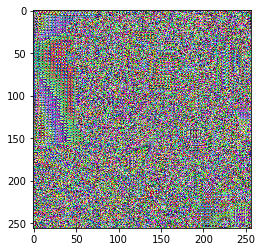

In [25]:
plt.imshow(result)

In [ ]:
result

In [ ]:
im_test = cv2.imread("/datasets/coco-2014-train/COCO_train2014_000000000009.jpg")
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)
im_test = cv2.resize(im_test, (256, 256))
im_test_to_feed = np.reshape(im_test, [1, im_test.shape[0], im_test.shape[1], im_test.shape[2]])
result = model_style_transfer.predict(im_test_to_feed)
result = np.reshape(result, [256, 256, 3])
plt.imshow(result)

In [ ]:
im_test.shape

In [ ]:
model_style_transfer.load_weights('weights/weights.hdf5')

In [ ]:
relu1_2.predict(np.array([im]))[0].shape